# Solutions Task 3
Author: Luis Denninger

In [1]:
import os
from functools import reduce
from pathlib import Path as P

import numpy as np

import torch
import torch.nn 
import torch.nn.functional as fun
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

import torchvision as tv

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import matplotlib.patches as patches
import seaborn as sn
from sklearn.metrics import confusion_matrix

import yaml

import copy

from tqdm import tqdm

import optuna

import pandas as pd

import plotly

from fvcore.nn import FlopCountAnalysis, flop_count_str, ActivationCountAnalysis

import ipdb

import inspect

import torchgadgets as tg

## Data

The dataset has provided tight bounding boxes around the animal's faces. Since this could possibly make the task even easier, we do not use them for the training as well as the evaluation dataset. In the training dataset, we use a random crop that is resized to 224x224 pixels in order to force a common size before applying any data augmentation step etc. During evaluation, we take crop around the center that spans the minimum of the image width and height and resize it to 224x224 pixels.

In [2]:
import torchgadgets as tg

tg.tools.set_random_seed(42)

data = tg.data.load_dataset('oxfordpet')

train_dataset = data['train_dataset']
test_dataset = data['test_dataset']

dog_inds = [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21,22, 24, 25, 28, 29, 30, 31, 34, 35, 36]
cat_inds = [0, 5, 6, 7, 8, 11, 20, 23, 26, 27, 32, 33]

category_names = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle',
    'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau',
    'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees',
    'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher',
    'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard',
    'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier',
    'wheaten_terrier', 'yorkshire_terrier'
]

print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))


Train dataset size: 3680
Test dataset size: 3669


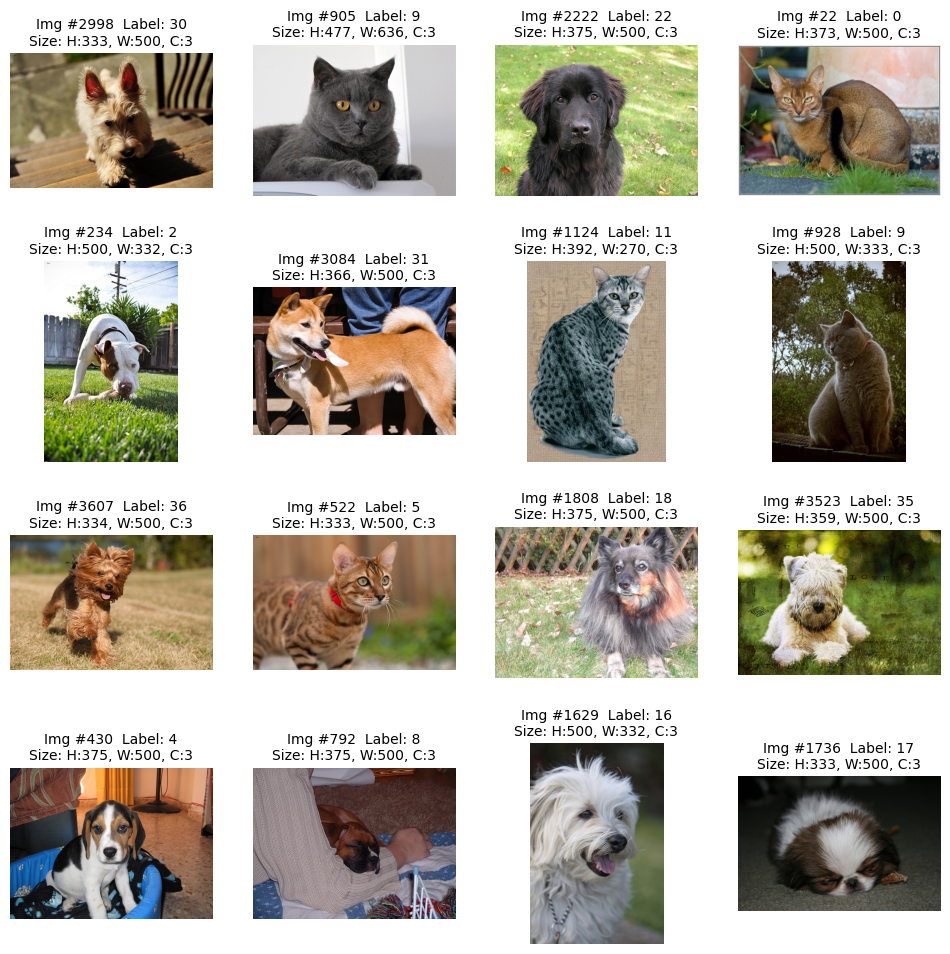

In [10]:
tg.visualization.visualize_dataset(test_dataset)

In [3]:
#max_height = 0
#ind_height = -1
#max_width = 0
#ind_width = -1
#min_height = 9999999999999999
#ind_height_min = -1
#min_width = 9999999999999999
#ind_width_min = -1
#
#category_images = {}
#
#for i in range(len(train_dataset)):
#    img = train_dataset[i][0]
#    img = tv.transforms.PILToTensor()(img)
#    _, height, width = img.shape
#    if height > max_height:
#        max_height = height
#        ind_height = i
#    if width > max_width:
#        max_width = width
#        ind_width = i
#    if height < min_height:
#        min_height = height
#        ind_height_min = i
#    if width < min_width:
#        min_width = width
#        ind_width_min = i
#    category_images[train_dataset[i][1]] = i
#
#print('Minimal Height:\t', min_height, '\t Index:\t', ind_height_min)        
#print('Maximal Height:\t', max_height, '\t Index:\t', ind_height)
#print('Minimal Width:\t', min_width, '\t Index:\t', ind_width_min)
#print('Maximal Width:\t', max_width, '\t Index:\t', ind_width)



In [4]:
#inds = [value for key, value in category_images.items()]
#tg.visualization.visualize_dataset(train_dataset, [ind_height_min, ind_height, ind_width_min, ind_width], label_names=category_names, layout=(2,2))

## Data Augmentation

In [5]:
# Take a random crop and resize the image to 224x224 to enforce the same size for all images to concatenate them to batches.
data_loading_transforms = [ {'type': 'random_resized_crop', 'size': (224, 224), 'scale': (0.08,1.0), 'ratio': (0.75, 1.3333), 'train': True, 'eval': False}]

test_data_loading_transforms = [{'type': 'dynamic_center_crop', 'train': False, 'eval': True},
                                {'type': 'resize', 'size': (224,224), 'train': False, 'eval': True}]

# All other transformations are applied to batches of images after data loading for higher computational efficiency.

tg.tools.set_random_seed(42)

# Define a custom dataset including the data augmentation and further functions to edit the dataset.
train_augmentation_dataset = tg.data.ImageDataset(train_dataset, data_loading_transforms)
test_augmentation_dataset = tg.data.ImageDataset(test_dataset, test_data_loading_transforms)




In [6]:
# Create mapping from original labels to dog (0) and cat (1) labels.
label_mapping = {}
for i in range(37):
    label_mapping[str(i)] = 0 if i in dog_inds else 1
# Remap the categories to dogs and cats within the dataset
train_augmentation_dataset.remap_labels(label_mapping)
test_augmentation_dataset.remap_labels(label_mapping)

# Take random 1000 random cat and 1000 random dog images.
CAT_IMAGES = 1000
DOG_IMAGES = 1000
random_inds = np.arange(len(train_augmentation_dataset))
np.random.shuffle(random_inds)

random_cat_inds = []
random_dog_inds = []
for i in random_inds:
    if len(random_cat_inds) >= CAT_IMAGES and len(random_dog_inds) >= DOG_IMAGES:
        break
    img, label = train_augmentation_dataset[i]
    if label == 0 and len(random_dog_inds) < DOG_IMAGES:
        random_dog_inds.append(i)
    elif label == 1 and len(random_cat_inds) < CAT_IMAGES:
        random_cat_inds.append(i)

train_augmentation_dataset.filter_dataset((random_cat_inds+random_dog_inds))


In [7]:
data_augmentation =   [   
                        {'type': 'cutmix', 'alpha': 300, 'prob': 1.0, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.5, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 90, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.5, 'hue': 0.3, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(3,3), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                        {'type': 'normalize', 'train': True, 'eval': True},
                    ]

## Task 1: Comparison ResNet, VGG and MobileNetV3

## ResNet-18

In [8]:
RESNET_MODEL_ARCHITECTURE =     [
                                    {'type': 'ResNet', 'size': 18, 'layers': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': tg.models.RESNET_FEATURE_DIM[18][1], 'out_features': 1024},
                                    {'type': 'batchnorm1d', 'num_features': 1024, 'eps':1e-05, 'momentum': 0.1},
                                    {'type': 'relu'},
                                    {'type': 'linear', 'in_features': 1024, 'out_features': 512},
                                    {'type': 'batchnorm1d', 'num_features': 512, 'eps':1e-05, 'momentum': 0.1},
                                    {'type': 'relu'},
                                    {'type': 'dropout', 'prob': 0.5},
                                    {'type': 'linear', 'in_features': 512, 'out_features': 128},
                                    {'type': 'batchnorm1d', 'num_features': 128, 'eps':1e-05, 'momentum': 0.1},
                                    {'type': 'relu'},
                                    {'type': 'linear', 'in_features': 128, 'out_features': 2},
                                ]


MODEL_CONFIG =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 64,
                            'num_epochs': 15,
                            'num_iterations': 0,
                            'learning_rate': 0.001,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': None
                            
                        }


In [ ]:
tg.training.trainNN(config=MODEL_CONFIG, train_loader=train_augmentation_dataset, test_loader=test_augmentation_dataset)